# $B_E$ speed dependancy

In [1]:
from src.notebook_to_latex import Equation, equation_dict
from rolldecayestimators import equations_ikeda_naked

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


# Purpose
Investigating the speed dependancy of the eddy damping $B_E$ by looking the the MDL database. Ikeda express the speed dependancy as:

In [2]:
Equation(equations_ikeda_naked.eq_eddy_speed, label='eq:eddy_speed')

<src.notebook_to_latex.Equation object>

But where does the 0.0016 term come from? Is there a better value, when looking at results from MDL db? It seems that it is a fit to the following results:
![](B_E_speed.PNG)

# Methodology
Create something similar to the plot above, but based on MDL DB. It can be assumed that for a ship ship without bilge keels the eddy damping $B_E$ represent the nonlinear part of the damping.
Using $B_1$, $B_2$ and $B_3$, $B_E$ should therefore represent what is in the $B_2$ coefficient. 

# Setup

In [3]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')
from reports.paper_writing import save_fig

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize


In [75]:
df_rolldecay = database.load(limit_score=0.98)
#df_rolldecay['BKL'].fillna(0,inplace=True)
scale_factor = df_rolldecay.scale_factor
df_rolldecay['V'] = df_rolldecay.ship_speed*1.852/3.6/np.sqrt(scale_factor)

In [91]:
mask = df_rolldecay['BKL'] == 0
df_bare_hull = df_rolldecay.loc[mask].copy()
exclude = [20147221]
mask = df_bare_hull['project_number'].isin(exclude)
df_bare_hull = df_bare_hull.loc[~mask]

In [92]:
ok = [  
    20064244,
    20095349,
    20095421,
    20157577,
    20157491,
]  # Visual inspection of pictures of models

In [93]:
#mask = df_bare_hull['project_number'].isin(ok)
#df_bare_hull = df_bare_hull.loc[mask].copy()

In [94]:
for loading_condition_id, df in df_bare_hull.groupby(by='loading_condition_id'):
    
    if len(df['ship_speed'].unique()) == 1:
        continue
        
    mask = df['ship_speed'] == 0
    df_zero_speed = df.loc[mask]
    
    if len(df_zero_speed) == 0:
        continue
        
    zero_speed = df_zero_speed.iloc[0].copy()
    
    factor = df['B_2A'] / zero_speed['B_2A']  ## Assuming that B_E is proportional to B_2        
    
    df_bare_hull.loc[df.index,r'B_E/B_E0'] = factor
           
        
    
    

In [95]:
Equation(equations_ikeda_naked.eq_K, label='eq:K')

<src.notebook_to_latex.Equation object>

In [96]:
lambda_K = lambdify(equations_ikeda_naked.eq_K.rhs)

In [97]:
lambda_eddy_speed = lambdify(equations_ikeda_naked.eq_eddy_speed_general.rhs)

In [98]:
lpp = df_bare_hull.lpp/scale_factor
df_bare_hull['K'] = lambda_K(L_pp=lpp, V=df_bare_hull.V, omega=df_bare_hull.omega0)
df_bare_hull[r'1/K'] = 1/df_bare_hull['K']

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
<string>:2: RuntimeWarning: invalid value encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in true_divide


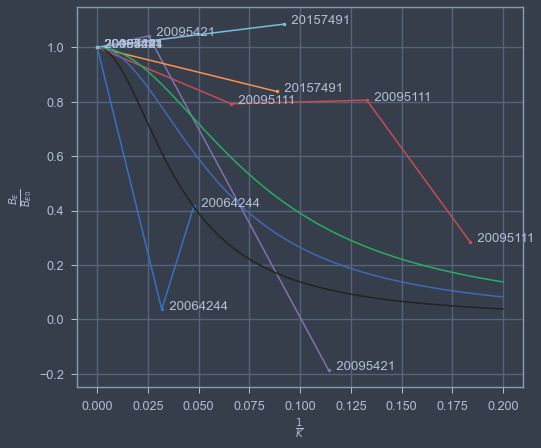

In [101]:
fig,ax=plt.subplots()

for loading_condition_id, df in df_bare_hull.groupby(by='loading_condition_id'):
    df.plot(x='1/K', y = r'B_E/B_E0', ax=ax, style = '.-')


for _, row in df_bare_hull.iterrows():
    ax.annotate(text='  %s' % row['project_number'], xy=(row['1/K'],row[r'B_E/B_E0']))
    
one_div_K = np.linspace(0,0.2,100)
k = 1/one_div_K

alphas = np.arange(0.04,0.10,0.02)
for alpha in alphas:
    ax.plot(one_div_K, lambda_eddy_speed(K=k, alpha=alpha), label=r'$\alpha:%0.2f$' % alpha)
    
ax.legend()
ax.set_xlabel(r'$\frac{1}{K}$')
ax.set_ylabel(r'$\frac{B_E}{B_{E0}}$')
ax.grid()
    
ax.get_legend().set_visible(False)

In [85]:
equations.B_e_equation

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi))

In [86]:
equations.B_2_hat_equation

Eq(B_2_hat, B_2/(Disp*beam**2*rho))

In [102]:
for p in df_bare_hull['project_path'].unique():
    
    mask = df_bare_hull['project_path'] == p
    project_number = df_bare_hull.loc[mask].iloc[0]['project_number']
    
    
    print('%s:%s' % (project_number,p))

20064244:\\sspa.local\gbg\ProjektArkiv\2006\20064244
20084942:\\sspa.local\gbg\ProjektArkiv\2008\20084942 Bluefin
20095421:\\sspa.local\gbg\ProjektArkiv\2009\20095421_STX_Polar_Supply
20095111:\\sspa.local\gbg\ProjektArkiv\2009\20095111
20157491:S:\2015\20157491-SDARI---twin-skeg-type-modular-carrier
